# Core Features: Lines and Planes in Parameter Space

This example covers the basic features of the `loss-landscapes` library, i.e. evaluating a model's loss function along lines or planes in parameter space in order to produce visualizations of the loss landscape.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# libraries
import os
import sys
import copy
import time
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model
from loss_landscapes.model_interface.model_parameters import ModelParameters, rand_u_like, rand_n_like, orthogonal_to
from loss_landscapes.contrib.functions import SimpleWarmupCaller, SimpleLossEvalCaller, log_refined_loss
from loss_landscapes.contrib.trajectories import flatten, reconstruct, propermap, PCATrajectoryTracker

## 1. Preliminary: Classifying MNIST

This notebook demonstrates how to accomplish a simple task: visualizing the loss landscape of a small fully connected feed-forward neural network on the MNIST image classification task. In this section the preliminaries (the model and the training procedure) are setup.

In [3]:
# training hyperparameters
IN_DIM = 28 * 28
OUT_DIM = 10
LR = 10 ** -2
BATCH_SIZE = 512
EPOCHS = 25
# contour plot resolution
STEPS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The cells in this section contain no code specific to the `loss-landscapes` library.

In [4]:
class MLPSmall(torch.nn.Module):
    """ Fully connected feed-forward neural network with one hidden layer. """
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 32)
        self.bn = torch.nn.BatchNorm1d(32)
        self.linear_2 = torch.nn.Linear(32, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        h = self.bn(h)
        return F.softmax(self.linear_2(h), dim=1)


class Flatten(object):
    """ Transforms a PIL image to a flat numpy array. """
    def __call__(self, sample):
        return np.array(sample, dtype=np.float32).flatten()    

In [5]:
log_path = '/global/cfs/cdirs/m636/geshi/exp/Mnist/optimization_trajectory/1'

def save_checkpoint(checkpoint):
    utctime = datetime.datetime.now(datetime.timezone.utc).strftime("%m-%d-%Y-%H:%M:%S")
    model_path = os.path.join(log_path, f'iter{checkpoint}-' + utctime + '.pt')
    torch.save({'model_state_dict': model.state_dict(),}, model_path)

In [6]:
def load_func(model, model_path):
    model.load_state_dict(torch.load(model_path)['model_state_dict'])

In [7]:
def train(model, optimizer, criterion, train_loader, epochs, device):
    """ Trains the given model with the given optimizer, loss function, etc. """
    model.train()
    # train model
    save_checkpoint(0)
    for epoch in tqdm(range(epochs), 'Training'):
        for count, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
        save_checkpoint(epoch+1)

    model.eval()

We then create the model and an instance of the MNIST dataset.

In [8]:
# download MNIST and setup data loaders
mnist_train = datasets.MNIST(root='/global/cfs/cdirs/m636/geshi/data/', train=True, download=True, transform=Flatten())
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=False)

# define model
model = MLPSmall(IN_DIM, OUT_DIM)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

## 2. Points in Parameter Space
The state of a neural network model represents a point in parameter space. Several functions in the `loss-landscapes` library require the user to provide instances of neural network models as arguments, where the model is taken to represent the point in parameter space corresponding to its parameters' state. Representing points as simply the models they relate to reduces the complexity of the client code.

In the cell below, a copy of the model before training is made, to preserve the model's initial state.

In [9]:
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)

Two common points of interest are the model initialization, and the model's final parameters after training. Similarly to the cell above, we can make a copy of the model after training. A copy of the model can be made at any time - this is up to the user, of course.

In [10]:
# train(model, optimizer, criterion, train_loader, EPOCHS, device)
model.load_state_dict(torch.load(os.path.join(log_path, 'iter25-12-13-2023-21:44:14.pt'))['model_state_dict'])

model_final = copy.deepcopy(model)

## 3. Load Trajectory Constructor

In [11]:
models_list = ['iter0-12-13-2023-21:43:29.pt',
            'iter1-12-13-2023-21:43:32.pt',
            'iter2-12-13-2023-21:43:34.pt',
            'iter3-12-13-2023-21:43:35.pt',
            'iter4-12-13-2023-21:43:37.pt',
            'iter5-12-13-2023-21:43:39.pt',
            'iter6-12-13-2023-21:43:41.pt',
            'iter7-12-13-2023-21:43:43.pt',
            'iter8-12-13-2023-21:43:44.pt',
            'iter9-12-13-2023-21:43:46.pt',
            'iter10-12-13-2023-21:43:48.pt',
            'iter11-12-13-2023-21:43:50.pt',
            'iter12-12-13-2023-21:43:51.pt',
            'iter13-12-13-2023-21:43:53.pt',
            'iter14-12-13-2023-21:43:55.pt',
            'iter15-12-13-2023-21:43:56.pt',
            'iter16-12-13-2023-21:43:58.pt',
            'iter17-12-13-2023-21:44:00.pt',
            'iter18-12-13-2023-21:44:02.pt',
            'iter19-12-13-2023-21:44:03.pt',
            'iter20-12-13-2023-21:44:05.pt',
            'iter21-12-13-2023-21:44:07.pt',
            'iter22-12-13-2023-21:44:09.pt',
            'iter23-12-13-2023-21:44:11.pt',
            'iter24-12-13-2023-21:44:12.pt',]
# 'iter25-12-13-2023-21:44:14.pt',

In [12]:
model_paths = [os.path.join(log_path, model_name) for model_name in models_list]

In [13]:
tracker = PCATrajectoryTracker(model_final, model_paths)

architecture [torch.Size([32, 784]), torch.Size([32]), torch.Size([32]), torch.Size([32]), torch.Size([10, 32]), torch.Size([10])]


In [14]:
tracker.load_checkpoints(load_func)

In [15]:
projections = tracker.dim_reduction()

In [25]:
projections.shape

(25, 2)

In [16]:
grids = propermap(projections, (0.2, 0.2), (40, 20))

In [17]:
flatten_grids = np.stack((grids[0].flatten(), grids[1].flatten()), axis=1)

In [18]:
flatten_grids.shape

(800, 2)

In [19]:
inverse_projections = tracker.inverse_project(flatten_grids)

In [20]:
inverse_projections.shape

(800, 25514)

In [21]:
coords_parameters = [reconstruct(inverse_projection, tracker.architecture) for inverse_projection in inverse_projections]

In [22]:
coords_parameters[0][0].shape

(32, 784)

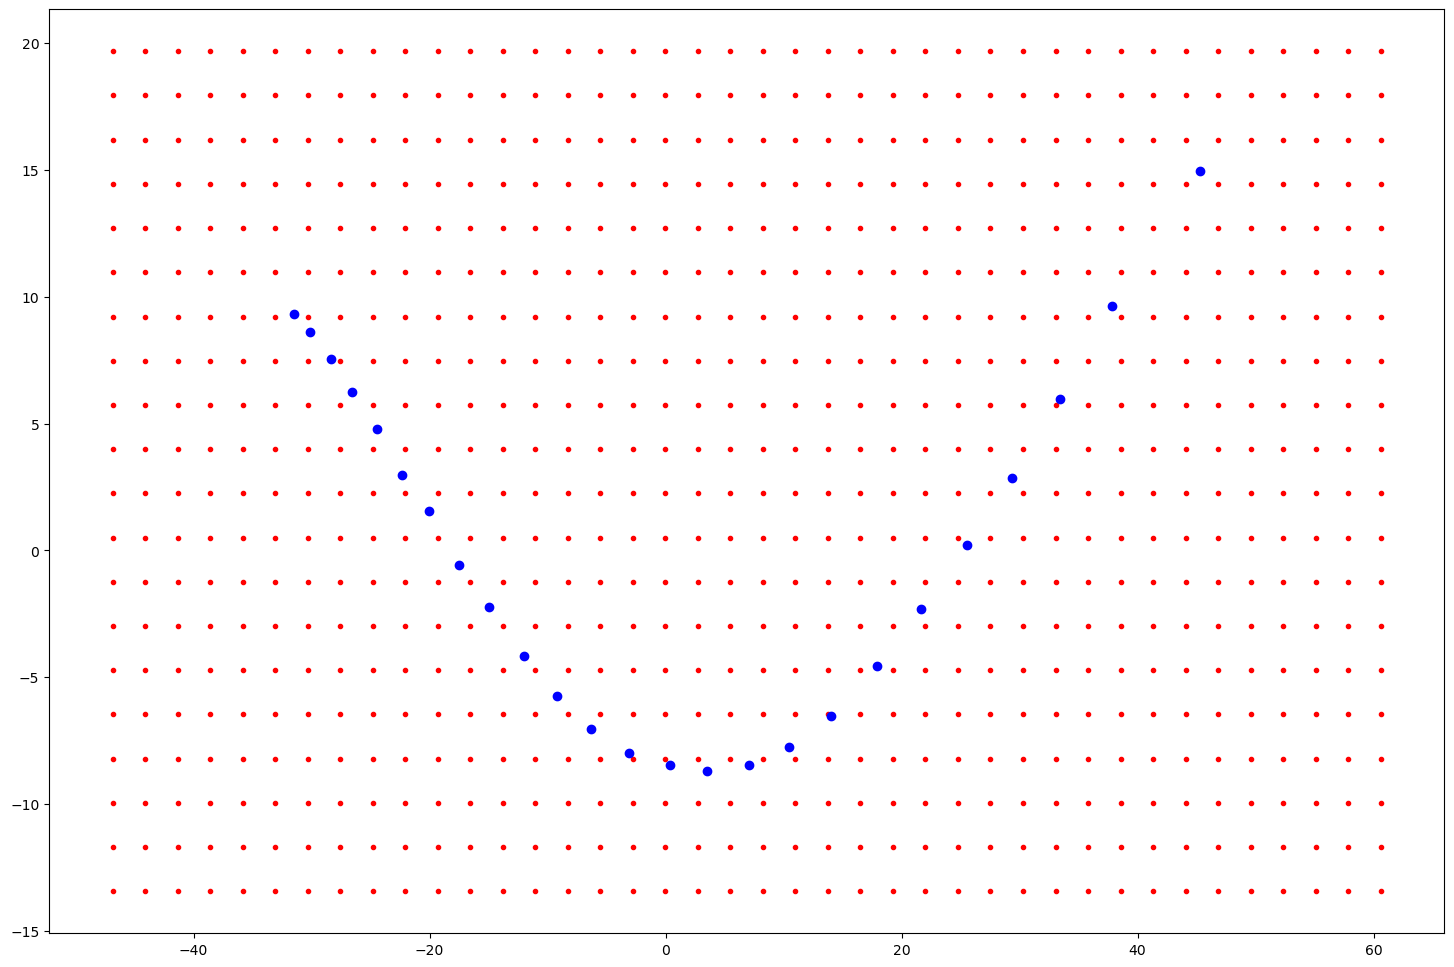

In [26]:
plt.scatter(flatten_grids[:,0], flatten_grids[:,1], marker='.', c='r')
plt.scatter(projections[:,0], projections[:,1], marker='o', c='b')

plt.show()

In [24]:
print(tracker.get_components())

[[-1.6152600e-14 -4.7623296e-14 -1.2421785e-14 ... -1.1825213e-03
  -2.1530655e-03  1.3878051e-03]
 [ 2.4982961e-07 -7.2491934e-12  1.8104378e-13 ...  3.8571813e-04
   5.9371075e-04 -1.5539055e-03]]


In [27]:
print(tracker.get_explained_variance_ratio())

[0.822582  0.0740553]


## 4. Evaluate losses

In [43]:
# data that the evaluator will use when evaluating loss
# download MNIST and setup data loaders

x, y = iter(train_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

In [33]:
flatten_grids

array([[-46.86929779, -13.44201508],
       [-44.11379666, -13.44201508],
       [-41.35829554, -13.44201508],
       ...,
       [ 55.08424387,  19.67672863],
       [ 57.839745  ,  19.67672863],
       [ 60.59524612,  19.67672863]])

In [40]:
X_cord = np.sort(np.array(list(set(flatten_grids[:,0]))))

In [42]:
Y_cord = np.sort(np.array(list(set(flatten_grids[:,1]))))

In [62]:
loss_data = []

In [63]:
for parameters in coords_parameters:
    model_wrapper = wrap_model(model_final)
    model_parameters = model_wrapper.get_module_parameters()
    for param_dst, param_src in zip(model_parameters, parameters):
        param_dst.copy_(torch.Tensor(param_src))
    with torch.no_grad():
        model_wrapper.train()
        metric(model_wrapper)
        model_wrapper.eval()
        loss = metric(model_wrapper)
    loss_data.append(loss)

In [58]:
loss_data_fin = np.array(loss_data)
loss_data_fin.resize(20, 40)

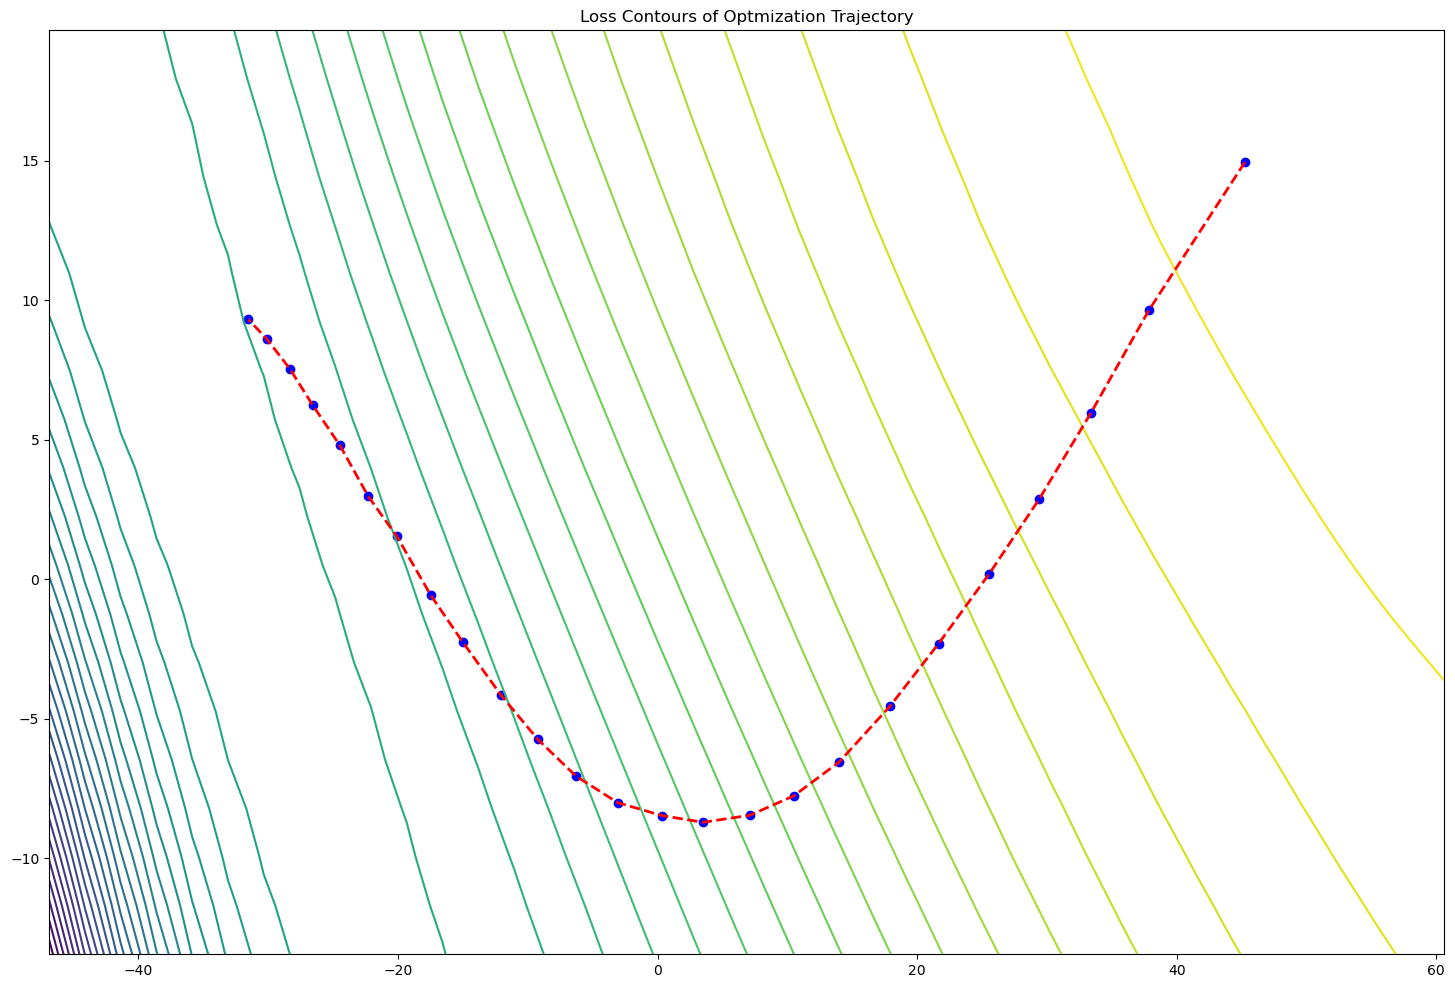

In [61]:
plt.contour(X_cord, Y_cord, loss_data_fin, levels=50)
plt.scatter(projections[:,0], projections[:,1], marker='o', c='b')
plt.plot(projections[:,0], projections[:,1], '--', linewidth=2, c='r')
plt.title('Loss Contours of Optmization Trajectory')
plt.show()